In [1]:
from PIL import Image
import face_recognition
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import os
import random

In [2]:
training_data = []
characters = {}
people = [p for p in os.listdir(f'../images/train') if os.path.isdir(f'../images/train/{p}')]
for i, person in enumerate(people):
    characters[person] = i
    files = os.listdir(f'../images/train/{person}')
    for file in files:
        path = f'../images/train/{person}/{file}'
        if path.endswith('.jpeg'):
            image = face_recognition.load_image_file(path)
            face_locations = face_recognition.face_locations(image)
            if len(face_locations):
                top, right, bottom, left = face_locations[0]
                face = image[top:bottom, left:right]
                face = cv2.resize(face, (100, 100))
                face = cv2.cvtColor(face, cv2.COLOR_RGB2GRAY)
                face = face.reshape(100, 100, 1)
                training_data.append([face, i])

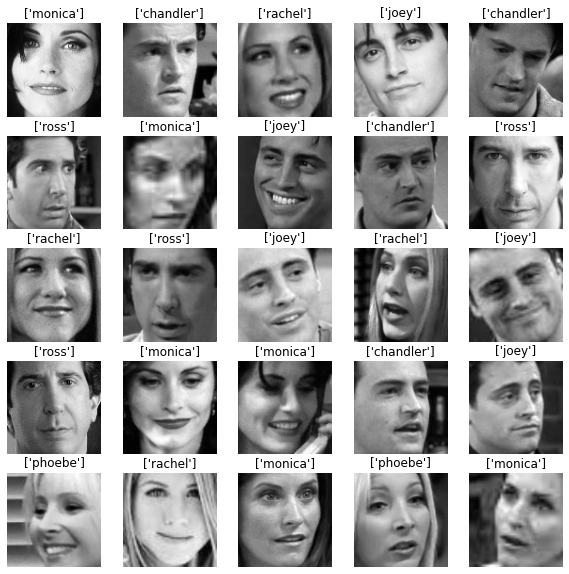

In [3]:
random.shuffle(training_data)
plt.figure(figsize=(10,10))

for i, (face, label) in enumerate(training_data[:25]):
    plt.subplot(5, 5, i+1)
    plt.imshow(face, cmap='gray')
    plt.axis("off")
    plt.title([k for k,v in characters.items() if label==v])


## Generate X, y and normalize X values

In [4]:
X = []
y = []

for image, label in training_data:
    X.append(image)
    y.append(label)
    
X = np.array(X).astype(float) / 255
y = np.array(y).astype(float) / 5


In [5]:
X.shape, y.shape

((174, 100, 100, 1), (174,))

## Models

In [6]:
dense_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(100, 100, 1)),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

2021-10-27 19:58:14.437134: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-27 19:58:14.441217: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-27 19:58:14.443802: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
CNN_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [8]:
CNN_model_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(250, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [9]:
dense_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

CNN_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

CNN_model_2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
from tensorflow.keras.callbacks import TensorBoard

tensor_board_denso = TensorBoard(log_dir='logs/denso')
dense_model.fit(X, y, batch_size=32, verbose=False,
               validation_split=0.15,
               epochs=100,
               callbacks=[tensor_board_denso])
print('Trained')
               

2021-10-27 19:58:14.738297: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-10-27 19:58:14.738325: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-10-27 19:58:14.739361: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-10-27 19:58:14.818145: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-27 19:58:14.847800: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz
2021-10-27 19:58:15.572931: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-10-27 19:58:15.572978: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-10-27 19:58:15.621239: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-10-27 19:58:15.633887: I tensorflow/core/pro

Trained


In [11]:
tensor_board_CNN = TensorBoard(log_dir='logs/cnn')
CNN_model.fit(X, y, batch_size=32, verbose=False,
               validation_split=0.15,
               epochs=100,
               callbacks=[tensor_board_CNN])
print('Trained')

2021-10-27 19:58:51.487384: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-10-27 19:58:51.487427: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-10-27 19:58:51.487462: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-10-27 19:58:52.674302: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-10-27 19:58:52.679427: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-10-27 19:58:52.957020: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-10-27 19:58:52.975113: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-10-27 19:58:52.988651: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/cnn/train/plugins/profile/2021_10_27_19_58_52
2021-10-27 19:58:52.989806: I tensorflow/core/profi

KeyboardInterrupt: 

In [ ]:
tensor_board_CNN2 = TensorBoard(log_dir='logs/cnn2')
CNN_model_2.fit(X, y, batch_size=32, verbose=False,
               validation_split=0.15,
               epochs=100,
               callbacks=[tensor_board_CNN2])
print('Trained')

## Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range = 50,
    width_shift_range = .3,
    height_shift_range = .3,
    shear_range=30,
    zoom_range=[.3, 1.3],
    vertical_flip=True,
    horizontal_flip=True
)

datagen.fit(X)
plt.figure(figsize=(20, 8))

for image, label in datagen.flow(X, y, batch_size=10, shuffle=False):
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(image[i].reshape(100, 100), cmap="gray")
    break
    

In [ ]:
dense_model_DA = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(100, 100, 1)),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

CNN_model_DA = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

CNN_model_2_DA = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape=(100, 100, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(250, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

In [ ]:
dense_model_DA.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

CNN_model_DA.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

CNN_model_2_DA.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
len(X) * .85,len(X) * .15

In [ ]:
X_train = X[:148]
X_test = X[148:]

y_train = y[:148]
y_test = y[148:]

In [ ]:
data_gen_train = datagen.flow(X_train, y_train, batch_size=32)

In [ ]:
tensor_board_dense_DA = TensorBoard(log_dir='logs/dense_da')
dense_model_DA.fit(
    data_gen_train,
    batch_size=32,
    verbose=False,
    validation_data=(X_test, y_test),
    epochs=100,
    steps_per_epoch=int(np.ceil(len(X_train) / float(32))),
    validation_steps=int(np.ceil(len(X_test) / float(32))),                   
    callbacks=[tensor_board_dense_DA]
)
print('Trained')

In [ ]:
tensor_board_CNN_DA = TensorBoard(log_dir='logs/cnn_da')
CNN_model_DA.fit(
    data_gen_train,
    batch_size=32,
    verbose=False,
    validation_data=(X_test, y_test),
    epochs=100,
    steps_per_epoch=int(np.ceil(len(X_train) / float(32))),
    validation_steps=int(np.ceil(len(X_test) / float(32))),                   
    callbacks=[tensor_board_CNN_DA]
)
print('Trained')

In [ ]:
tensor_board_CNN_2_DA = TensorBoard(log_dir='logs/cnn2_da')
CNN_model_2_DA.fit(
    data_gen_train,
    batch_size=32,
    verbose=False,
    validation_data=(X_test, y_test),
    epochs=100,
    steps_per_epoch=int(np.ceil(len(X_train) / float(32))),
    validation_steps=int(np.ceil(len(X_test) / float(32))),                   
    callbacks=[tensor_board_CNN_2_DA]
)
print('Trained')